# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** [Davin Ghani Ananta Kusuma]
- **Email:** [anantadavin4@gmail.com]
- **ID Dicoding:** [davin_ghani]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library untuk pengolahan data
import os, shutil
import zipfile
import random
import pathlib
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Library untuk pemrosesan gambar
import cv2
from PIL import Image
import skimage
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Library untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"davinghani","key":"7ff663671308ed5efa251599e7c86b5c"}'}

In [3]:
# Menyimpan kaggle.json di direktori yang benar
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Mengubah permission agar file kaggle.json dapat diakses
!chmod 600 /root/.kaggle/kaggle.json

# Mengunduh dataset dari Kaggle (gunakan URL dari halaman dataset Kaggle)
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

# Mengekstrak file zip yang diunduh
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: /content/dataset/S

In [4]:
# Melihat isi folder dataset
import os
os.listdir('/content/dataset')

['Shoe vs Sandal vs Boot Dataset']

### Data Preprocessing

#### Split Dataset

In [5]:
# Direktori dataset asli dan target direktori untuk train, validation, dan test
original_dataset_dir = '/content/dataset/Shoe vs Sandal vs Boot Dataset'
train_dir = '/content/dataset/train'
validation_dir = '/content/dataset/validation'
test_dir = '/content/dataset/test'

# Membuat folder train, validation, test jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Mendapatkan daftar kelas dari folder dataset
class_names = os.listdir(original_dataset_dir)

# Membuat folder untuk setiap kelas di train, validation, dan test
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Membagi gambar untuk setiap kelas menjadi train, validation, dan test
for class_name in class_names:
    class_folder = os.path.join(original_dataset_dir, class_name)
    images = os.listdir(class_folder)

    # Membagi gambar menjadi train, validation, test
    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
    validation_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Memindahkan gambar ke folder yang sesuai
    for image_name in train_images:
        shutil.move(os.path.join(class_folder, image_name), os.path.join(train_dir, class_name, image_name))

    for image_name in validation_images:
        shutil.move(os.path.join(class_folder, image_name), os.path.join(validation_dir, class_name, image_name))

    for image_name in test_images:
        shutil.move(os.path.join(class_folder, image_name), os.path.join(test_dir, class_name, image_name))

In [6]:
# Fungsi untuk menghitung jumlah gambar dan resolusi gambar dalam sebuah folder
def check_image_count_and_resolution(directory):
    image_count = 0
    resolutions = {}  # Untuk menyimpan resolusi gambar unik
    # Menelusuri folder dan subfolder
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            print(f"Folder kelas: {class_name}")
            total_images = 0
            for image_name in os.listdir(class_dir):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Pastikan hanya gambar
                    total_images += 1
                    image_path = os.path.join(class_dir, image_name)
                    with Image.open(image_path) as img:
                        resolution = img.size  # Mendapatkan ukuran gambar (lebar, tinggi)
                        resolutions[image_name] = resolution
            image_count += total_images
            print(f"Total gambar di {class_name}: {total_images}")

    print(f"\nJumlah gambar total: {image_count}")
    return resolutions, image_count

# Memeriksa dataset training, validation, dan testing
train_resolutions, train_count = check_image_count_and_resolution('/content/dataset/train')
validation_resolutions, validation_count = check_image_count_and_resolution('/content/dataset/validation')
test_resolutions, test_count = check_image_count_and_resolution('/content/dataset/test')

Folder kelas: Shoe
Total gambar di Shoe: 4000
Folder kelas: Sandal
Total gambar di Sandal: 4000
Folder kelas: Boot
Total gambar di Boot: 4000

Jumlah gambar total: 12000
Folder kelas: Shoe
Total gambar di Shoe: 500
Folder kelas: Sandal
Total gambar di Sandal: 500
Folder kelas: Boot
Total gambar di Boot: 500

Jumlah gambar total: 1500
Folder kelas: Shoe
Total gambar di Shoe: 500
Folder kelas: Sandal
Total gambar di Sandal: 500
Folder kelas: Boot
Total gambar di Boot: 500

Jumlah gambar total: 1500


In [7]:
# Menampilkan contoh resolusi gambar dari train, validation, dan test
print("\nContoh resolusi gambar di train set:", list(train_resolutions.items())[:5])
print("\nContoh resolusi gambar di validation set:", list(validation_resolutions.items())[:5])
print("\nContoh resolusi gambar di test set:", list(test_resolutions.items())[:5])


Contoh resolusi gambar di train set: [('Shoe (4930).jpg', (136, 102)), ('Shoe (2269).jpg', (136, 102)), ('Shoe (2806).jpg', (136, 102)), ('Shoe (1760).jpg', (136, 102)), ('Shoe (2247).jpg', (136, 102))]

Contoh resolusi gambar di validation set: [('Shoe (462).jpg', (136, 102)), ('Shoe (1445).jpg', (136, 102)), ('Shoe (297).jpg', (136, 102)), ('Shoe (2084).jpg', (136, 102)), ('Shoe (1302).jpg', (136, 102))]

Contoh resolusi gambar di test set: [('Shoe (3063).jpg', (136, 102)), ('Shoe (888).jpg', (136, 102)), ('Shoe (1643).jpg', (136, 102)), ('Shoe (3121).jpg', (136, 102)), ('Shoe (2717).jpg', (136, 102))]


In [8]:
# ImageDataGenerator untuk training data dengan augmentasi gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi gambar
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator untuk validation dan testing data tanpa augmentasi gambar
test_datagen = ImageDataGenerator(rescale=1./255)

# Memuat gambar dari direktori training dengan augmentasi
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(150, 150),  # Ukuran gambar yang digunakan untuk training
    batch_size=32,
    class_mode='categorical'  # Menggunakan klasifikasi multi-kelas
)

# Memuat gambar dari direktori validation tanpa augmentasi
validation_generator = test_datagen.flow_from_directory(
    '/content/dataset/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Memuat gambar dari direktori testing tanpa augmentasi
test_generator = test_datagen.flow_from_directory(
    '/content/dataset/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


## Modelling

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Membuat model Sequential
model = Sequential()

# Menambahkan layer Conv2D pertama (Convolutional layer)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))

# Menambahkan MaxPooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Menambahkan layer Conv2D kedua
model.add(Conv2D(64, (3, 3), activation='relu'))

# Menambahkan MaxPooling layer kedua
model.add(MaxPooling2D(pool_size=(2, 2)))

# Menambahkan layer Conv2D ketiga
model.add(Conv2D(128, (3, 3), activation='relu'))

# Menambahkan MaxPooling layer ketiga
model.add(MaxPooling2D(pool_size=(2, 2)))

# Mengubah output menjadi bentuk satu dimensi (Flattening)
model.add(Flatten())

# Menambahkan layer Dense untuk klasifikasi
model.add(Dense(512, activation='relu'))

# Menambahkan layer output (jumlah neuron sesuai dengan jumlah kelas)
model.add(Dense(3, activation='softmax'))  # 3 kelas: Shoe, Sandal, Boot

# Menyusun model dengan optimizer dan loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,203 (72.61 MB)

 Trainable params: 19,035,203 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Menambahkan callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_count // 32,  # Total langkah per epoch
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_count // 32,  # Total langkah validasi
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.4985 - loss: 1.0378

375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 197ms/step - accuracy: 0.4988 - loss: 1.0374 - val_accuracy: 0.7317 - val_loss: 0.6247
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7086 - loss: 0.6688

375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 190ms/step - accuracy: 0.7086 - loss: 0.6687 - val_accuracy: 0.7704 - val_loss: 0.5046
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.7675 - loss: 0.5469

375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 187ms/step - accuracy: 0.7675 - loss: 0.5469 - val_accuracy: 0.8533 - val_loss: 0.3584
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8079 - loss: 0.4608

375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 185ms/step - accuracy: 0.8079 - loss: 0.4608 - val_accuracy: 0.8668 - val_loss: 0.3086
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8392 - loss: 0.4024

375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 188ms/step - accuracy: 0.8392 - loss: 0.4024 - val_accuracy: 0.8872 - val_loss: 0.2799
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8569 - loss: 0.3542

375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.8569 - loss: 0.3541 - val_accuracy: 0.9144 - val_loss: 0.2325
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8793 - loss: 0.3071

375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 187ms/step - accuracy: 0.8793 - loss: 0.3072 - val_accuracy: 0.9389 - val_loss: 0.1721
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 184ms/step - accuracy: 0.8880 - loss: 0.2895 - val_accuracy: 0.9368 - val_loss: 0.1802
Epoch 9/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 185ms/step - accuracy: 0.8869 - loss: 0.2853 - val_accuracy: 0.9130 - val_loss: 0.2123
Epoch 10/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8986 - loss: 0.2638

375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 187ms/step - accuracy: 0.8986 - loss: 0.2637 - val_accuracy: 0.9450 - val_loss: 0.1611
Epoch 11/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - accuracy: 0.9082 - loss: 0.2392 - val_accuracy: 0.9246 - val_loss: 0.2056
Epoch 12/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 184ms/step - accuracy: 0.9103 - loss: 0.2283 - val_accuracy: 0.9402 - val_loss: 0.1683
Epoch 13/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - accuracy: 0.9202 - loss: 0.2208 - val_accuracy: 0.9395 - val_loss: 0.1481
Epoch 14/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 186ms/step - accuracy: 0.9215 - loss: 0.2131 - val_accuracy: 0.9450 - val_loss: 0.1346
Epoch 15/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9258 - loss: 0.2023

375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 186ms/step - accuracy: 0.9258 - loss: 0.2023 - val_accuracy: 0.9457 - val_loss: 0.1323
Epoch 16/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9276 - loss: 0.1986

375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 185ms/step - accuracy: 0.9276 - loss: 0.1986 - val_accuracy: 0.9558 - val_loss: 0.1153
Epoch 17/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 191ms/step - accuracy: 0.9293 - loss: 0.1919 - val_accuracy: 0.9307 - val_loss: 0.1934
Epoch 18/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 185ms/step - accuracy: 0.9238 - loss: 0.1989 - val_accuracy: 0.9463 - val_loss: 0.1519
Epoch 19/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - accuracy: 0.9272 - loss: 0.1889 - val_accuracy: 0.9538 - val_loss: 0.1339
Epoch 20/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9331 - loss: 0.1750

375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 185ms/step - accuracy: 0.9331 - loss: 0.1750 - val_accuracy: 0.9565 - val_loss: 0.1127
Epoch 21/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.9409 - loss: 0.1663 - val_accuracy: 0.9423 - val_loss: 0.1581
Epoch 22/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 182ms/step - accuracy: 0.9349 - loss: 0.1755 - val_accuracy: 0.9463 - val_loss: 0.1426
Epoch 23/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 184ms/step - accuracy: 0.9316 - loss: 0.1806 - val_accuracy: 0.9504 - val_loss: 0.1249
Epoch 24/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9377 - loss: 0.1766

375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.9377 - loss: 0.1766 - val_accuracy: 0.9572 - val_loss: 0.0981
Epoch 25/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 182ms/step - accuracy: 0.9441 - loss: 0.1537 - val_accuracy: 0.9490 - val_loss: 0.1365


## Evaluasi dan Visualisasi

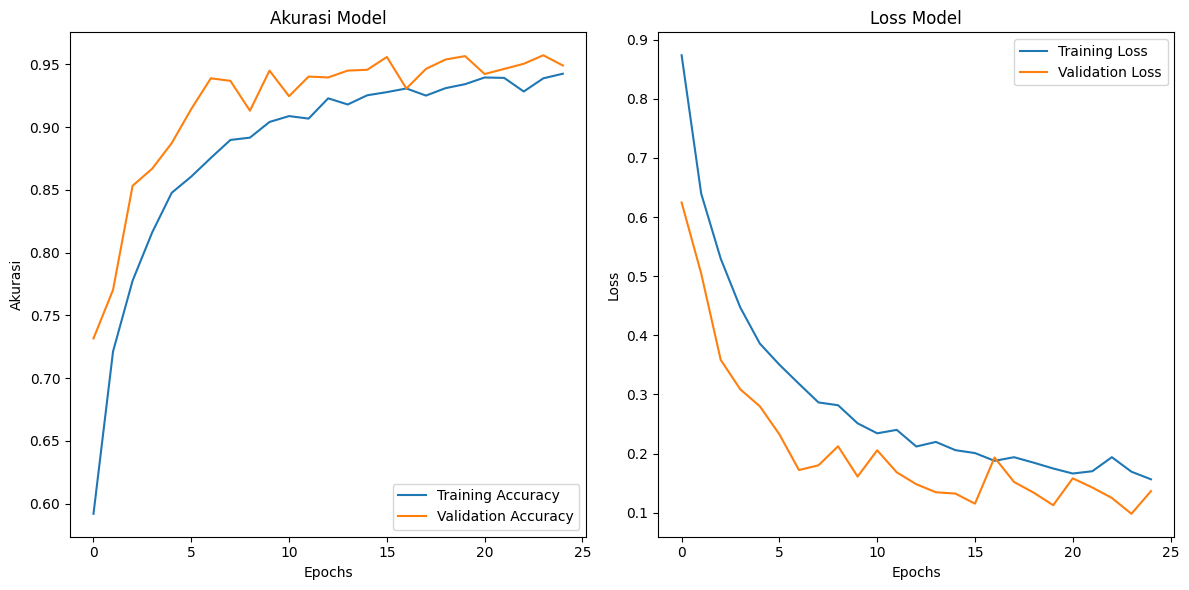

In [11]:
import matplotlib.pyplot as plt

# Mengambil data akurasi dan loss dari history
history_dict = history.history

# Membuat plot akurasi
plt.figure(figsize=(12, 6))

# Plot akurasi training dan validation
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss training dan validation
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Evaluasi model menggunakan data test
evaluation = model.evaluate(
    test_generator,
    steps= test_generator.samples // test_generator.batch_size
)

# Menampilkan hasil evaluasi
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9566 - loss: 0.1273
Loss: 0.12301646173000336
Accuracy: 0.95652174949646


## Konversi Model

In [17]:
import tensorflowjs as tfjs
# Menyimpan model dalam format SavedModel
save_path = 'shoe_sandal_boot_model_saved/'
tf.saved_model.save(model, save_path)

# Menyimpan model dalam format TF-Lite (untuk perangkat mobile)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('shoe_sandal_boot_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Menyimpan model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, '/content/shoe_sandal_boot_model_js')

Saved artifact at '/tmp/tmpc6rwhd4a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134786525385872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134786525385296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134786525385488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134786525386064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134786525393168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134786525393936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134786525393744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134786525394128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134786525394896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134786525395664: TensorSpec(shape=(), dtype=tf.resource, name=None)


failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)